# Example notebook to show how the new chemical mixture creator works

In [8]:
import os
import sys
from pathlib import Path

In [9]:
vimms_path = '/Users/simon/git/vimms'
sys.path.append(vimms_path)
# path to fixtures so we can load HMDB
BASE_DIR = os.path.abspath(Path(vimms_path,'tests','integration', 'fixtures'))

In [10]:
%load_ext autoreload
%autoreload 2

from vimms.Common import *
from vimms.Controller import AIF
from vimms.Environment import Environment
from vimms.MassSpec import IndependentMassSpectrometer

# Noise for the MS
from vimms.Noise import GaussianPeakNoise,  UniformSpikeNoise

# Chemical creator import
from vimms.Chemicals import ChemicalMixtureCreator
from vimms.ChemicalSamplers import UniformRTAndIntensitySampler, UniformMS2Sampler, CRPMS2Sampler, GaussianChromatogramSampler, DatabaseFormulaSampler, UniformMZFormulaSampler, MGFMS2Sampler




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load HMDB

In [11]:
HMDB = load_obj(Path(BASE_DIR, 'hmdb_compounds.p'))

In [12]:
N_CHEMS = 10
MZ_RANGE = [(0, 1050)]
RT_RANGE = [(300, 500)]

In [13]:
# sample RT and log intensity uniformly. See class def for min and max log intensity
# returns actual intensity, but samples in log space
uu = UniformRTAndIntensitySampler(min_rt = 300, max_rt = 500)

# a sampler that samples MS2 uniform between 50 and the mass of the formula.
# number ofo MS2 peaks is poisson with mean poiss_peak_mean
us = UniformMS2Sampler(poiss_peak_mean=5)

# OR a CRP MS2 sampler
us = CRPMS2Sampler()

# OR load from an .mgf file - here we filter to only keep spectra with 20 peaks or fewer
# and sample without replacement
us = MGFMS2Sampler(Path(BASE_DIR,'small_mgf.mgf'), max_peaks=20, replace=False)

# generates Gaussian chromatograms
cs = GaussianChromatogramSampler()

# generates formulas from HMDB
hf = DatabaseFormulaSampler(HMDB)

# or, samples them from a uniform - so just mz rather then formulas
# resulting in UnknownChemical objects instead of known_chemical ones
hf = UniformMZFormulaSampler()

# The chemical mixture creator object

cm = ChemicalMixtureCreator(hf, rt_and_intensity_sampler=uu, 
                            adduct_prior_dict=ADDUCT_DICT_POS_MH,
                            chromatogram_sampler=cs,
                            ms2_sampler = us)

d = cm.sample(MZ_RANGE,RT_RANGE,N_CHEMS,2)

2020-08-26 22:18:47.219 | DEBUG    | vimms.ChemicalSamplers:__init__:142 - Loaded 9 spectra from /Users/simon/git/vimms/tests/integration/fixtures/small_mgf.mgf
2020-08-26 22:18:47.231 | DEBUG    | vimms.Chemicals:sample:604 - Sampled rt and intensity values and chromatograms


KeyboardInterrupt: 

Print the sampled chemicals, and their children

In [116]:
d.sort(key=lambda x: x.rt)
for chem in d:
    print(chem)
    for child in chem.children:
        print('\t',child)

UnknownChemical mz=134.7209 rt=316.00 max_intensity=380400.38
	 MSN Fragment mz=43.0000 ms_level=2
	 MSN Fragment mz=55.0000 ms_level=2
	 MSN Fragment mz=56.0000 ms_level=2
	 MSN Fragment mz=70.0000 ms_level=2
	 MSN Fragment mz=73.0000 ms_level=2
	 MSN Fragment mz=74.0000 ms_level=2
	 MSN Fragment mz=97.0000 ms_level=2
	 MSN Fragment mz=98.0000 ms_level=2
	 MSN Fragment mz=116.0000 ms_level=2
	 MSN Fragment mz=133.0000 ms_level=2
	 MSN Fragment mz=134.0000 ms_level=2
UnknownChemical mz=37.8086 rt=341.67 max_intensity=9790291.08
	 MSN Fragment mz=354.9900 ms_level=2
	 MSN Fragment mz=358.9500 ms_level=2
	 MSN Fragment mz=385.1000 ms_level=2
	 MSN Fragment mz=408.9900 ms_level=2
	 MSN Fragment mz=409.0600 ms_level=2
	 MSN Fragment mz=414.0600 ms_level=2
	 MSN Fragment mz=424.0100 ms_level=2
	 MSN Fragment mz=427.0800 ms_level=2
	 MSN Fragment mz=439.0000 ms_level=2
	 MSN Fragment mz=439.0400 ms_level=2
UnknownChemical mz=360.9205 rt=343.34 max_intensity=8369730.92
	 MSN Fragment mz=53.03

Create and run an example controller. In this case, AIF.

In [101]:
controller = AIF(MZ_RANGE[0][0],MZ_RANGE[0][1])
ionisation_mode = POSITIVE
scan_time_dict = {1:0.6,2:0.06}


mz_noise = GaussianPeakNoise(0.001)
intensity_noise = GaussianPeakNoise(0.1,log_space=True)

# This is new: spike noise which ensures no scans are empty
# first argument is density: how many spikes to sample per unit m/z. Second is max spike intensity
spike_noise = UniformSpikeNoise(0.01,1e3)


# note the None in the call in place of a peak sampler object - this isn't used anywhere in this example
mass_spec = IndependentMassSpectrometer(ionisation_mode, d, None,
                                        scan_duration_dict = scan_time_dict, 
                                        mz_noise = mz_noise,
                                        intensity_noise = intensity_noise,
                                        spike_noise = spike_noise)


In [102]:
env = Environment(mass_spec, controller, 300, 600, progress_bar=True)

In [103]:
set_log_level_warning()
# run the simulation
env.run()
env.write_mzML('.','test.mzML')

(600.000s) ms_level=1: 100%|█████████▉| 299.99999999999994/300 [00:04<00:00, 62.39it/s]  


# Example using new multi-sample

In [64]:
# make a 5 v 5 case control experiment
n_control = 5
n_case = 5

# create a list of groups -- this is the order the chemical lists will return in
group_list = ['control' for i in range(n_control)] + ['case' for i in range(n_case)]

# create a dictionary describing what we want to happen in the groups
# e.g. in the 'case' group, things are not missing, and 90% of them are changing
group_dict = {'case': {'missing_probability':0.0, 'changing_probability':0.9}}


from vimms.Chemicals import MultipleMixtureCreator
from vimms.Noise import GaussianPeakNoise

# use the intensity peak noise to add some sample noise
intensity_noise = GaussianPeakNoise(sigma=0.2,log_space=True)


# use the list of chemicals from the previous example
mmc = MultipleMixtureCreator(d, group_list, group_dict, intensity_noise = intensity_noise)
chem_lists = mmc.generate_chemical_lists()

Check the chemical lists produced with a heatmap


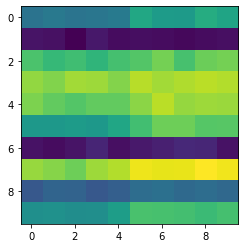

In [65]:
import pylab as plt
%matplotlib inline
intensities = []
for cl in chem_lists:
    new_intensities = [0 for c in d]
    for c in cl:
        c_pos = d.index(c.original_chemical)
        new_intensities[c_pos] = c.max_intensity
    intensities.append(new_intensities)
intensities = np.array(intensities).T
plt.imshow(np.log(intensities+1))